In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,TensorDataset
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<Figure size 1000x500 with 0 Axes>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [5]:
df = pd.read_csv('amazon_reviews.csv')
df.head(10)

sentiments                                     cleaned_review  \
0   positive  i wish would have gotten one earlier love it a...   
1    neutral  i ve learned this lesson again open the packag...   
2    neutral          it is so slow and lags find better option   
3    neutral  roller ball stopped working within months of m...   
4    neutral  i like the color and size but it few days out ...   
5   positive  overall love this mouse the size weight clicki...   
6    neutral                                 it stopped working   
7   positive  my son uses school issued chromebook for schoo...   
8   negative  loved this cute little mouse but it broke afte...   
9   negative  should ve spent the money to get quality produ...   

   cleaned_review_length  review_score  
0                     19           5.0  
1                     88           1.0  
2                      9           2.0  
3                     12           1.0  
4                     21           1.0  
5                     68           3.0  
6                      3           1.0  
7                    170           1.0  
8                     17           1.0  
9                     17           1.0

In [7]:
print(df.isna().sum())

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64


In [9]:
df=df.dropna()

In [11]:
print(df.isna().sum())

sentiments               0
cleaned_review           0
cleaned_review_length    0
review_score             0
dtype: int64


In [13]:
def text_preprocessing(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    tokens = word_tokenize(text.lower())  
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]  
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [15]:
df.loc[:, 'cleaned_review'] = df['cleaned_review'].apply(text_preprocessing)

In [17]:
df['cleaned_review']

0        wish would gotten one earlier love make workin...
1        learned lesson open package use product right ...
2                              slow lag find better option
3        roller ball stopped working within month minim...
4            like color size day return period hold charge
                               ...                        
17335    love speaker love take anywhere charge phone w...
17336              use house easy connect loud clear music
17337    bass good battery amazing much better charge t...
17338                                                 love
17339                                         mono speaker
Name: cleaned_review, Length: 17337, dtype: object

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

In [21]:
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = pd.get_dummies(df['sentiments']).values

In [23]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [25]:
train_data = TensorDataset(torch.from_numpy(X_train).long(), torch.from_numpy(y_train).float())
val_data = TensorDataset(torch.from_numpy(X_val).long(), torch.from_numpy(y_val).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=50)
val_loader = DataLoader(val_data, shuffle=True, batch_size=50)

In [27]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, n_layers, drop_prob=0.5):
        super(LSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1])
        out = self.fc(lstm_out)
        return out


In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:

epochs = 20
output_size = 3
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(tokenizer.word_index) + 1
lstm_model = LSTM(vocab_size, embedding_dim, hidden_dim, output_size, n_layers).to(device)

In [33]:
def print_model_summary(model, model_name):
    print(f"Model Summary for {model_name}")
    print(model)
    print("\n")

In [35]:
print_model_summary(lstm_model, "LSTM")

Model Summary for LSTM
LSTM(
  (embedding): Embedding(8504, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)




In [37]:

lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calculate_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(labels, preds)
    
    return precision, recall, accuracy

def train_and_validate(model, optimizer, criterion, train_loader, val_loader, epochs, device):
    train_losses, val_losses, val_accs = [], [], []
    train_precisions, train_recalls, train_accuracies = [], [], []
    val_precisions, val_recalls, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_precision, total_train_recall, total_train_accuracy = 0, 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()


            _, preds = torch.max(output, 1)
            precision, recall, accuracy = calculate_metrics(preds, torch.max(labels, 1)[1])
            total_train_precision += precision
            total_train_recall += recall
            total_train_accuracy += accuracy


        model.eval()
        total_val_loss, total_val_precision, total_val_recall, total_val_accuracy = 0, 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output, torch.max(labels, 1)[1])
                total_val_loss += val_loss.item()


                _, preds = torch.max(output, 1)
                precision, recall, accuracy = calculate_metrics(preds, torch.max(labels, 1)[1])
                total_val_precision += precision
                total_val_recall += recall
                total_val_accuracy += accuracy

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_precision = total_train_precision / len(train_loader)
        avg_train_recall = total_train_recall / len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_precision = total_val_precision / len(val_loader)
        avg_val_recall = total_val_recall / len(val_loader)
        avg_val_accuracy = total_val_accuracy / len(val_loader)

        train_losses.append(avg_train_loss)
        train_precisions.append(avg_train_precision)
        train_recalls.append(avg_train_recall)
        train_accuracies.append(avg_train_accuracy)

        val_losses.append(avg_val_loss)
        val_precisions.append(avg_val_precision)
        val_recalls.append(avg_val_recall)
        val_accuracies.append(avg_val_accuracy)

        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Train Precision: {avg_train_precision}, Train Recall: {avg_train_recall}, Train Accuracy: {avg_train_accuracy}')
        print(f'Validation Loss: {avg_val_loss}, Validation Precision: {avg_val_precision}, Validation Recall: {avg_val_recall}, Validation Accuracy: {avg_val_accuracy}')

    return train_losses, train_precisions, train_recalls, train_accuracies, val_losses, val_precisions, val_recalls, val_accuracies






In [41]:
print("LSTM Start Training: \n")
lstm_train_losses, lstm_train_precisions, lstm_train_recalls, lstm_train_accuracies, lstm_val_losses, lstm_val_precisions, lstm_val_recalls, lstm_val_accuracies = train_and_validate(
    lstm_model, lstm_optimizer, criterion, train_loader, val_loader, epochs, device
)

# saving the trained model
#torch.save(lstm_model.state_dict(), 'lstm_model.pth')


LSTM Start Training: 

Epoch: 1/20, Train Loss: 0.5730452347788022, Train Precision: 0.7576890991305837, Train Recall: 0.763767512305945, Train Accuracy: 0.763767512305945
Validation Loss: 0.48253457248210907, Validation Precision: 0.8284237762636338, Validation Recall: 0.7991746031746031, Validation Accuracy: 0.7991746031746031
Epoch: 2/20, Train Loss: 0.364285015748988, Train Precision: 0.8705304991873526, Train Recall: 0.8638205225293454, Train Accuracy: 0.8638205225293454
Validation Loss: 0.41390829661062783, Validation Precision: 0.8578448337879965, Validation Recall: 0.8457460317460321, Validation Accuracy: 0.8457460317460321
Epoch: 3/20, Train Loss: 0.2398946881160247, Train Precision: 0.9195599523814899, Train Recall: 0.9136690647482006, Train Accuracy: 0.9136690647482006
Validation Loss: 0.41628491474049434, Validation Precision: 0.8667902116919467, Validation Recall: 0.8604126984126984, Validation Accuracy: 0.8604126984126984
Epoch: 4/20, Train Loss: 0.1439838534046849, Train

In [43]:
def plot_losses(Model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {Model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_metrics(Model_name, train_metrics, val_metrics, metric_name, epochs):
    plt.plot(range(1, epochs + 1), train_metrics, label=f'Train {metric_name}')
    plt.plot(range(1, epochs + 1), val_metrics, label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name} for {Model_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

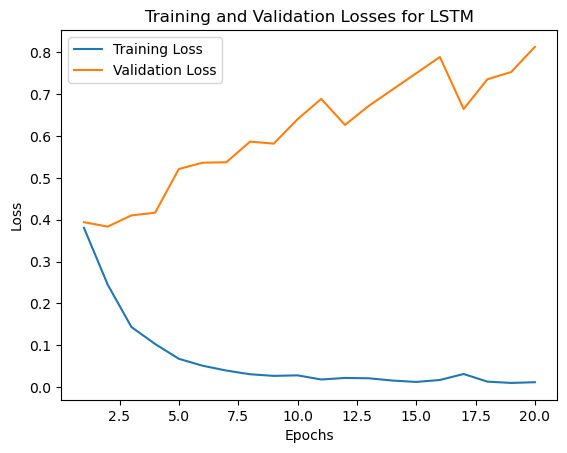

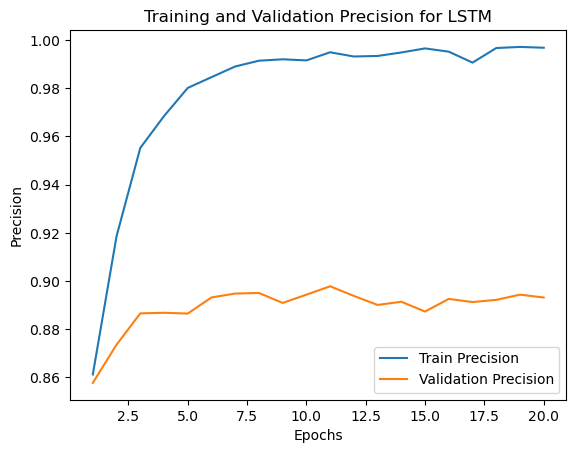

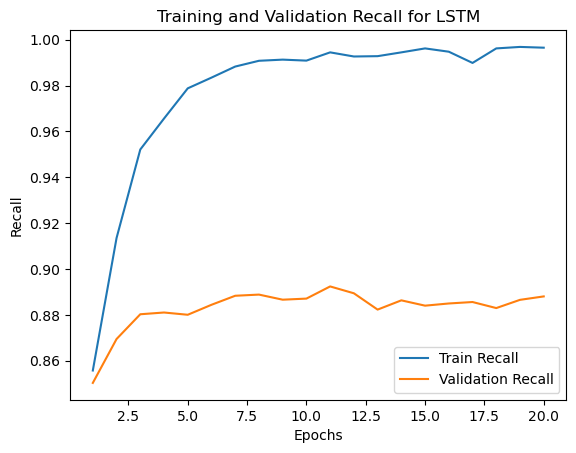

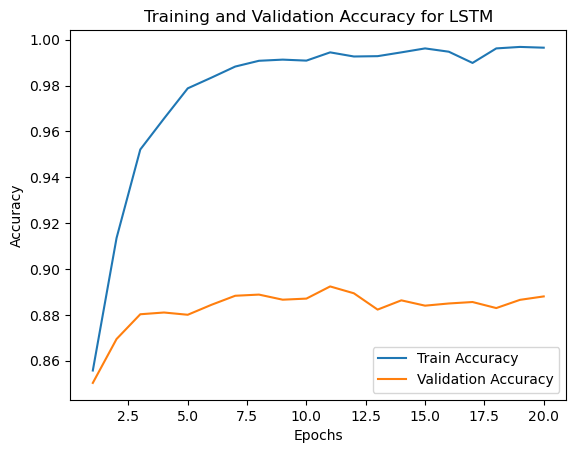

In [56]:

plot_losses("LSTM", lstm_train_losses, lstm_val_losses, epochs)
plot_metrics("LSTM", lstm_train_precisions, lstm_val_precisions, "Precision", epochs)
plot_metrics("LSTM", lstm_train_recalls, lstm_val_recalls, "Recall", epochs)
plot_metrics("LSTM", lstm_train_accuracies, lstm_val_accuracies, "Accuracy", epochs)

In [45]:

print("\nFinal Metrics after Training:")
print(f"Final Training Accuracy: {lstm_train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {lstm_val_accuracies[-1]:.4f}")
print(f"Final Training Precision: {lstm_train_precisions[-1]:.4f}")
print(f"Final Validation Precision: {lstm_val_precisions[-1]:.4f}")
print(f"Final Training Recall: {lstm_train_recalls[-1]:.4f}")
print(f"Final Validation Recall: {lstm_val_recalls[-1]:.4f}")



Final Metrics after Training:
Final Training Accuracy: 0.9937
Final Validation Accuracy: 0.8869
Final Training Precision: 0.9942
Final Validation Precision: 0.8944
Final Training Recall: 0.9937
Final Validation Recall: 0.8869


In [47]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_metrics(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            _, preds = torch.max(output, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
   
    cm = confusion_matrix(np.argmax(all_labels, axis=1), all_preds)
    
    
    report = classification_report(np.argmax(all_labels, axis=1), all_preds)
   
    acc = accuracy_score(np.argmax(all_labels, axis=1), all_preds)
    
    return cm, report, acc




print("Evaluating LSTM model:")
lstm_cm, lstm_report, lstm_acc = evaluate_metrics(lstm_model, val_loader, device)
print("Confusion Matrix:\n", lstm_cm)
print("Classification Report:\n", lstm_report)
print("Accuracy:", lstm_acc)


Evaluating LSTM model:
Confusion Matrix:
 [[ 212   74   29]
 [  26 1060  162]
 [   9   94 1802]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75       315
           1       0.86      0.85      0.86      1248
           2       0.90      0.95      0.92      1905

    accuracy                           0.89      3468
   macro avg       0.88      0.82      0.85      3468
weighted avg       0.89      0.89      0.88      3468

Accuracy: 0.8863898500576701


In [ ]:
import tkinter as tk
from tkinter import simpledialog, messagebox

def predict_sentiment(model, review, tokenizer, max_len, device):
    review_cleaned = text_preprocessing(review)
    sequence = tokenizer.texts_to_sequences([review_cleaned])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    input_tensor = torch.from_numpy(padded_sequence).long().to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
        predicted_index = torch.argmax(prediction, dim=1).item()
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_map[predicted_index]

def on_predict():
    review = text_entry.get("1.0", "end-1c")
    if review.strip() == "":
        messagebox.showinfo("Prediction", "Please enter a review for prediction.")
    else:
        
        model_to_use = lstm_model
        predicted_sentiment = predict_sentiment(model_to_use, review, tokenizer, max_len, device)
        messagebox.showinfo("Prediction", f"The predicted sentiment of the review is: {predicted_sentiment}")

root = tk.Tk()
root.title("Sentiment Analysis of Reviews")


text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(padx=10, pady=10)


lstm_button = tk.Radiobutton(root, text="LSTM", value='LSTM', state='disabled')  
lstm_button.pack()


predict_button = tk.Button(root, text="Predict Sentiment", command=on_predict)
predict_button.pack(pady=10)

root.mainloop()
